In [180]:
import os
import csv
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from scipy.stats import sem, t
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [181]:
BRCA1_function_data = "BRCA1_data_function_ddg.csv"
BRCA1_dbnsfp_data  = "BRCA1_dbNSFP_data.csv"

BRCA2_function_data = "BRCA2_data_function_ddg.csv"
BRCA2_dbnsfp_data  = "BRCA2_dbNSFP_data.csv"

PALB2_function_data = "PALB2_data_function_ddg.csv"
PALB2_dbnsfp_data  = "PALB2_dbNSFP_data.csv"

RAD51C_function_data = "RAD51C_data_function_ddg.csv"
RAD51C_dbnsfp_data  = "RAD51C_dbNSFP_data.csv"

In [182]:
#def calculate_auc_with_ci(df, column, label):
#    aucs = []
#    pr_aucs = []
#    n_bootstrap = 100
#    for _ in range(n_bootstrap):
#        sample = resample(df, replace=True)
#        sample = sample.dropna(subset=[label, column])
#        if not sample.empty:
#            try:
#                auc = roc_auc_score(sample[label], sample[column])
#                aucs.append(auc)
#                pr_auc = average_precision_score(sample[label], sample[column])
#                pr_aucs.append(pr_auc)
#            except ValueError:
#                pass
#    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
#    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))

#    return np.mean(aucs), auc_ci, np.mean(pr_aucs), pr_auc_ci


def calculate_auc_with_ci(df, column, label, random_state=42):
    np.random.seed(random_state)  # Set the seed for reproducibility
    
    aucs = []
    pr_aucs = []
    max_f1_scores = []  
    fprs = [] 
    n_bootstrap = 200
    
    for _ in range(n_bootstrap):
        positive = df[df[label] == 1]
        negative = df[df[label] == 0]
        min_size = min(len(positive), len(negative))
        positive_resampled = resample(positive, replace=False, n_samples=min_size)
        negative_resampled = resample(negative, replace=False, n_samples=min_size)
        sample = pd.concat([positive_resampled, negative_resampled])
        sample = resample(sample, replace=True)
        sample = sample.dropna(subset=[label, column])
        if sample.empty:
            continue
        try:
            auc = roc_auc_score(sample[label], sample[column])
            aucs.append(auc)
            pr_auc = average_precision_score(sample[label], sample[column])
            pr_aucs.append(pr_auc)
            fpr, tpr, thresholds = roc_curve(sample[label], sample[column])
            specificity = 1 - fpr
            f1_scores_at_thresholds = 2 * (tpr * specificity) / (tpr + specificity + 1e-10)  
            max_f1_index = np.argmax(f1_scores_at_thresholds)
            max_f1 = f1_scores_at_thresholds[max_f1_index]
            max_f1_scores.append(max_f1)
            fprs.append(fpr[max_f1_index])  
            
        except ValueError:
            pass
    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))
    max_f1_ci = t.interval(0.95, len(max_f1_scores) - 1, loc=np.mean(max_f1_scores), scale=sem(max_f1_scores))
    fpr_ci = t.interval(0.95, len(fprs) - 1, loc=np.mean(fprs), scale=sem(fprs))

    return (
        np.mean(aucs), auc_ci,
        np.mean(pr_aucs), pr_auc_ci,
        np.mean(max_f1_scores), max_f1_ci,
        np.mean(fprs), fpr_ci
    )


metrics_with_ci = [
    ("AUC", "AUC_CI_low", "AUC_CI_high"),
    ("PI_AUC", "PR_AUC_low", "PR_AUC_high"),
    ("F1_Score", "F1_CI_low", "F1_CI_high"),
    ("FRP_Score", "FRP_CI_low", "FRP_CI_high")  
]

def format_with_ci(df, metrics_with_ci):
    new_df = df.copy()
    for metric, ci_low, ci_high in metrics_with_ci:
        try:
            new_df[metric] = new_df[metric].astype(float).round(4).astype(str) + " (" + new_df[ci_low].astype(float).round(4).astype(str) + " - " + new_df[ci_high].astype(float).round(4).astype(str) + ")"
        except ValueError:
            print(f"Skipping metric {metric} due to non-numeric data.")
        new_df = new_df.drop(columns=[ci_low, ci_high])
    return new_df

In [183]:
map_function_dict = {'FUNC':'Normal', 'LOF':'Abnormal', 'INT': 'INT', 'VUS': 'INT',
                         'Neutral': "Normal", 'Deleterious': 'Abnormal',
                         'Normal': "Normal", 'Abnormal': 'Abnormal', 
                     'Intermediate': 'INT', 'intermediate': 'INT'}

In [184]:
def extract_integer_from_string(string):
    pattern = r'\d+'
    matches = re.findall(pattern, string)
    
    if matches:
        return int(matches[0])
    else:
        return None


    
keep_mut = ['D1818G', 'N1819S']    
def process_function_data(function_data, dbnsfp_data, map_function_dict):
    function_df = pd.read_csv(function_data)
    dbnsfp_df = pd.read_csv(dbnsfp_data)
    is_rankscore_column = [column.strip() for column in dbnsfp_df.columns if column.endswith('rankscore')]
    columns_to_keep = ['mutations', 'ClinVar_Class'] + is_rankscore_column
    dbnsfp_df = dbnsfp_df[columns_to_keep]
    function_df[['Protein_model', 'model_structure']] = function_df['dtype'].str.split("_", expand=True)
    
    function_df = function_df[(function_df['model_structure'] == "complex") | 
                                          (function_df['model'].isin(["1JNX", "2W18"]))]
    
    function_df['predictor_struct'] = function_df['predictor'] + "_" + function_df['Protein_model'] + "_" + function_df['model']
    cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
    function_df = function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)

    wide_df = function_df.pivot_table(index=['mutations', 'Class'], 
                                      columns='predictor_struct', values='ddg', aggfunc='first')

    wide_df = wide_df.reset_index()

    dbnsfp_function_df = pd.merge(dbnsfp_df, wide_df, on='mutations', how='left')
    dbnsfp_function_df['Class'] =  dbnsfp_function_df['Class'].fillna(dbnsfp_function_df['ClinVar_Class'])
    dbnsfp_function_df['Class'] = dbnsfp_function_df['Class'].map(map_function_dict)
    dbnsfp_function_df = dbnsfp_function_df[dbnsfp_function_df['Class'] != 'INT']
    dbnsfp_function_df['label'] = dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})
    dbnsfp_function_BRCT_df = dbnsfp_function_df[~dbnsfp_function_df['FoldX_AF2_4OFB'].isna() | dbnsfp_function_df['mutations'].isin(keep_mut)]
    
    dbnsfp_function_BRCT_df = dbnsfp_function_BRCT_df.reset_index(drop=True)
    dbnsfp_function_RING_df = dbnsfp_function_df[~dbnsfp_function_df['FoldX_crystal_7LYB'].isna()]
    dbnsfp_function_RING_df = dbnsfp_function_RING_df.reset_index(drop=True)
    data_all_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [], 'F1_CI_low': [], 
                     'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [], 'TYPE': []}
    data_BRCT_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [], 'F1_CI_low': [], 
                      'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [],'TYPE': []}
    data_RING_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [], 'F1_Score': [], 'F1_CI_low': [], 
                      'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [],'TYPE': []}
    for predictor_struct in function_df['predictor_struct'].unique():
        aucs, auc_ci, pr_aucs, pr_auc_ci,  f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(
            dbnsfp_function_BRCT_df, predictor_struct, 'label'
        )
        #print(function_df)
        data_BRCT_dict['name'].append(predictor_struct)
        data_BRCT_dict['AUC'].append(aucs)
        data_BRCT_dict['AUC_CI_low'].append(auc_ci[0])
        data_BRCT_dict['AUC_CI_high'].append(auc_ci[1])
        data_BRCT_dict['PI_AUC'].append(pr_aucs)
        data_BRCT_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_BRCT_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_BRCT_dict['F1_Score'].append(f1)
        data_BRCT_dict['F1_CI_low'].append(f1_ci[0])
        data_BRCT_dict['F1_CI_high'].append(f1_ci[1])
        data_BRCT_dict['FRP_Score'].append(fpr)
        data_BRCT_dict['FRP_CI_low'].append(fpr_ci[0])
        data_BRCT_dict['FRP_CI_high'].append(fpr_ci[1])
        data_BRCT_dict['TYPE'].append('Stability Predictor')
    
    for predictor in is_rankscore_column:
        aucs, auc_ci, pr_aucs, pr_auc_ci,  f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(
            dbnsfp_function_BRCT_df, predictor, 'label')
        data_BRCT_dict['name'].append(predictor)
        data_BRCT_dict['AUC'].append(aucs)
        data_BRCT_dict['AUC_CI_low'].append(auc_ci[0])
        data_BRCT_dict['AUC_CI_high'].append(auc_ci[1])
        data_BRCT_dict['PI_AUC'].append(pr_aucs)
        data_BRCT_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_BRCT_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_BRCT_dict['F1_Score'].append(f1)
        data_BRCT_dict['F1_CI_low'].append(f1_ci[0])
        data_BRCT_dict['F1_CI_high'].append(f1_ci[1])
        data_BRCT_dict['FRP_Score'].append(fpr)
        data_BRCT_dict['FRP_CI_low'].append(fpr_ci[0])
        data_BRCT_dict['FRP_CI_high'].append(fpr_ci[1])
        data_BRCT_dict['TYPE'].append("dbNSFP")
    
    for predictor_struct in function_df['predictor_struct'].unique():
        aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(
            dbnsfp_function_RING_df, predictor_struct, 'label'
        )
        #print(dbnsfp_function_RING_df.Class.value_counts())
        data_RING_dict['name'].append(predictor_struct)
        data_RING_dict['AUC'].append(aucs)
        data_RING_dict['AUC_CI_low'].append(auc_ci[0])
        data_RING_dict['AUC_CI_high'].append(auc_ci[1])
        data_RING_dict['PI_AUC'].append(pr_aucs)
        data_RING_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_RING_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_RING_dict['F1_Score'].append(f1)
        data_RING_dict['F1_CI_low'].append(f1_ci[0])
        data_RING_dict['F1_CI_high'].append(f1_ci[1])
        data_RING_dict['FRP_Score'].append(fpr)
        data_RING_dict['FRP_CI_low'].append(fpr_ci[0])
        data_RING_dict['FRP_CI_high'].append(fpr_ci[1])
        data_RING_dict['TYPE'].append('Stability Predictor')
    
    for predictor in is_rankscore_column:
        aucs, auc_ci, pr_aucs, pr_auc_ci,  f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(
            dbnsfp_function_RING_df, predictor, 'label'
        )
        #print(dbnsfp_function_RING_df.label.value_counts())
        data_RING_dict['name'].append(predictor)
        data_RING_dict['AUC'].append(aucs)
        data_RING_dict['AUC_CI_low'].append(auc_ci[0])
        data_RING_dict['AUC_CI_high'].append(auc_ci[1])
        data_RING_dict['PI_AUC'].append(pr_aucs)
        data_RING_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_RING_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_RING_dict['F1_Score'].append(f1)
        data_RING_dict['F1_CI_low'].append(f1_ci[0])
        data_RING_dict['F1_CI_high'].append(f1_ci[1])
        data_RING_dict['FRP_Score'].append(fpr)
        data_RING_dict['FRP_CI_low'].append(fpr_ci[0])
        data_RING_dict['FRP_CI_high'].append(fpr_ci[1])
        data_RING_dict['TYPE'].append("dbNSFP")
    
    for predictor in is_rankscore_column:
        #print(predictor)
        aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci,fpr, fpr_ci = calculate_auc_with_ci(
            dbnsfp_function_df, predictor, 'label'
        )
        data_all_dict['name'].append(predictor)
        data_all_dict['AUC'].append(aucs)
        data_all_dict['AUC_CI_low'].append(auc_ci[0])
        data_all_dict['AUC_CI_high'].append(auc_ci[1])
        data_all_dict['PI_AUC'].append(pr_aucs)
        data_all_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_all_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_all_dict['F1_Score'].append(f1)
        data_all_dict['F1_CI_low'].append(f1_ci[0])
        data_all_dict['F1_CI_high'].append(f1_ci[1])
        data_all_dict['FRP_Score'].append(fpr)
        data_all_dict['FRP_CI_low'].append(fpr_ci[0])
        data_all_dict['FRP_CI_high'].append(fpr_ci[1])
        data_all_dict['TYPE'].append("dbNSFP")

    result_BRCA1_all_df = pd.DataFrame(data_all_dict).sort_values(by="AUC", ascending=False)
    result_BRCA1_BRCT_df = pd.DataFrame(data_BRCT_dict).sort_values(by="AUC", ascending=False)
    result_BRCA1_RING_df = pd.DataFrame(data_RING_dict).sort_values(by="AUC", ascending=False)
    
    return dbnsfp_function_df, result_BRCA1_all_df, result_BRCA1_BRCT_df, result_BRCA1_RING_df

def filter_df_AUC(df):
    filter_dbnsfp_df = df[df['TYPE'] == 'dbNSFP'].head(10)
    filter_ddg_df = df[df['TYPE'] == 'Stability Predictor']
    final_df = pd.concat([filter_dbnsfp_df, filter_ddg_df], axis=0)
    final_df = final_df.sort_values(by="AUC", ascending=False)
    final_df = final_df.reset_index(drop=True)
    final_df['name'] = final_df['name'].str.replace('_rankscore', '')
    return final_df

In [185]:
BRCA1_data_df, BRCA1_results_df, BRCT_df, RING_df = process_function_data(BRCA1_function_data, 
                                                                          BRCA1_dbnsfp_data, map_function_dict)
BRCT_df = BRCT_df[~BRCT_df['AUC'].isna()]
RING_df = RING_df[~RING_df['AUC'].isna()]
BRCA1_results_format_df = format_with_ci(BRCA1_results_df, metrics_with_ci)
BRCT_format_df = format_with_ci(BRCT_df, metrics_with_ci)
RING_format_df = format_with_ci(RING_df, metrics_with_ci)

BRCT_format_df.to_csv('BRCA1_AUC_results.csv', index=None)
RING_format_df.to_csv("BRCA1_RING_AUC_results.csv", index=None)
BRCT_format_df.to_csv("BRCA1_BRCT_AUC_results.csv", index=None)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-

In [186]:
BRCA2_function_df = pd.read_csv(BRCA2_function_data)
BRCA2_dbnsfp_df = pd.read_csv(BRCA2_dbnsfp_data)
is_rankscore_column = [column for column in BRCA2_dbnsfp_df.columns if column.endswith('rankscore')]
BRCA2_function_df[['Protein_model', 'model_structure']] = BRCA2_function_df['dtype'].str.split("_", expand=True)
BRCA2_function_df = BRCA2_function_df[BRCA2_function_df['model_structure'] == "complex"]


BRCA2_function_df['predictor_struct'] = BRCA2_function_df['predictor'] + "_" + BRCA2_function_df['Protein_model'] + "_" + BRCA2_function_df['model']
cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
BRCA2_function_df = BRCA2_function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
class_df = BRCA2_function_df[['mutations', 'Class']]
class_df = class_df.drop_duplicates().reset_index(drop=True)
wide_df = BRCA2_function_df.pivot_table(index=['mutations'], 
                                      columns=['predictor_struct'], values='ddg')
wide_df = wide_df.reset_index()
wide_df = pd.merge(wide_df, class_df, on='mutations')
wide_df['POS'] = wide_df['mutations'].apply(lambda x: extract_integer_from_string(x) +79)
wide_df['ref'] = wide_df['mutations'].str[0]
wide_df['alt'] = wide_df['mutations'].str[-1]
wide_df['new_mutations'] = wide_df['ref'] + wide_df['POS'].astype('str') + wide_df['alt']
#print(wide_df.new_mutations.tolist())
BRCA2_dbnsfp_function_df = pd.merge(BRCA2_dbnsfp_df, wide_df, left_on='mutations', right_on='new_mutations', how='left')
BRCA2_dbnsfp_function_df = BRCA2_dbnsfp_function_df[BRCA2_dbnsfp_function_df['aaalt'] != 'X']
BRCA2_dbnsfp_function_df['Class'] =  BRCA2_dbnsfp_function_df['Class'].fillna(BRCA2_dbnsfp_function_df['ClinVar_Class'])
BRCA2_dbnsfp_function_df['Class'] = BRCA2_dbnsfp_function_df['Class'].map(map_function_dict)
BRCA2_dbnsfp_function_df = BRCA2_dbnsfp_function_df[BRCA2_dbnsfp_function_df['Class'] != 'INT']
BRCA2_dbnsfp_function_df['label'] = BRCA2_dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})
ddg_cols = BRCA2_function_df['predictor_struct'].unique()


data_BRCA2_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [],
                   'F1_CI_low': [], 'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [],'TYPE': []}

data_BRCA2_dbd_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [],
                   'F1_CI_low': [], 'F1_CI_high': [],'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [], 'TYPE': []}


BRCA2_dbnsfp_dbd_function_df = BRCA2_dbnsfp_function_df[~BRCA2_dbnsfp_function_df['FoldX_AF2_1MJE'].isna()]
BRCA2_dbnsfp_dbd_function_df = BRCA2_dbnsfp_dbd_function_df.reset_index(drop=True)


for predictor_struct in BRCA2_function_df['predictor_struct'].unique():
    aucs, auc_ci, pr_aucs, pr_auc_ci,  f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(BRCA2_dbnsfp_function_df, 
                                                            predictor_struct, 'label')
    data_BRCA2_dict['name'].append(predictor_struct)
    data_BRCA2_dict['AUC'].append(aucs)
    data_BRCA2_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dict['F1_Score'].append(f1)
    data_BRCA2_dict['F1_CI_low'].append(f1_ci[0])
    data_BRCA2_dict['F1_CI_high'].append(f1_ci[1])
    data_BRCA2_dict['FRP_Score'].append(fpr)
    data_BRCA2_dict['FRP_CI_low'].append(fpr_ci[0])
    data_BRCA2_dict['FRP_CI_high'].append(fpr_ci[1])
    data_BRCA2_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    #    print(predictor)
    aucs, auc_ci, pr_aucs, pr_auc_ci,  f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(BRCA2_dbnsfp_function_df, predictor, 'label')
    data_BRCA2_dict['name'].append(predictor)
    data_BRCA2_dict['AUC'].append(aucs)
    data_BRCA2_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dict['F1_Score'].append(f1)
    data_BRCA2_dict['F1_CI_low'].append(f1_ci[0])
    data_BRCA2_dict['F1_CI_high'].append(f1_ci[1])
    data_BRCA2_dict['FRP_Score'].append(fpr)
    data_BRCA2_dict['FRP_CI_low'].append(fpr_ci[0])
    data_BRCA2_dict['FRP_CI_high'].append(fpr_ci[1])
    data_BRCA2_dict['TYPE'].append("dbNSFP")
        

for predictor_struct in BRCA2_function_df['predictor_struct'].unique():
    aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci,fpr, fpr_ci = calculate_auc_with_ci(BRCA2_dbnsfp_dbd_function_df, 
                                                            predictor_struct, 'label')
    data_BRCA2_dbd_dict['name'].append(predictor_struct)
    data_BRCA2_dbd_dict['AUC'].append(aucs)
    data_BRCA2_dbd_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dbd_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dbd_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dbd_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dbd_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dbd_dict['F1_Score'].append(f1)
    data_BRCA2_dbd_dict['F1_CI_low'].append(f1_ci[0])
    data_BRCA2_dbd_dict['F1_CI_high'].append(f1_ci[1])
    data_BRCA2_dbd_dict['FRP_Score'].append(fpr)
    data_BRCA2_dbd_dict['FRP_CI_low'].append(fpr_ci[0])
    data_BRCA2_dbd_dict['FRP_CI_high'].append(fpr_ci[1])
    data_BRCA2_dbd_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    #    print(predictor)
    aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci,fpr, fpr_ci = calculate_auc_with_ci(BRCA2_dbnsfp_dbd_function_df, predictor, 'label')
    data_BRCA2_dbd_dict['name'].append(predictor)
    data_BRCA2_dbd_dict['AUC'].append(aucs)
    data_BRCA2_dbd_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dbd_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dbd_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dbd_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dbd_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dbd_dict['F1_Score'].append(f1)
    data_BRCA2_dbd_dict['F1_CI_low'].append(f1_ci[0])
    data_BRCA2_dbd_dict['F1_CI_high'].append(f1_ci[1])
    data_BRCA2_dbd_dict['FRP_Score'].append(fpr)
    data_BRCA2_dbd_dict['FRP_CI_low'].append(fpr_ci[0])
    data_BRCA2_dbd_dict['FRP_CI_high'].append(fpr_ci[1])
    data_BRCA2_dbd_dict['TYPE'].append("dbNSFP")


/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-

In [187]:

result_BRCA2_df = pd.DataFrame(data_BRCA2_dict)
result_BRCA2_df = result_BRCA2_df.sort_values(by="AUC", ascending=False)
result_BRCA2_dbd_df = pd.DataFrame(data_BRCA2_dbd_dict)
result_BRCA2_dbd_df = result_BRCA2_dbd_df.sort_values(by="AUC", ascending=False)
BRCA2_dbnsfp_function_out_df =BRCA2_dbnsfp_function_df[~BRCA2_dbnsfp_function_df['label'].isna()]
BRCA2_dbnsfp_function_out_df.to_csv("BRCA2_function_dbnsfp_data.csv", index=None)

In [188]:
result_BRCA2_format_df = format_with_ci(result_BRCA2_df, metrics_with_ci)
result_BRCA2_format_df.to_csv('BRCA2_AUC_results.csv', index=None)
result_BRCA2_dbd_format_df = format_with_ci(result_BRCA2_dbd_df, metrics_with_ci)
result_BRCA2_dbd_format_df.to_csv('result_BRCA2_dbd_results.csv', index=None)


In [189]:
RAD51C_function_df = pd.read_csv(RAD51C_function_data)
RAD51C_dbnsfp_df = pd.read_csv(RAD51C_dbnsfp_data)
is_rankscore_column = [column for column in RAD51C_dbnsfp_df.columns if column.endswith('rankscore')]
RAD51C_function_df[['Protein_model', 'model_structure']] = RAD51C_function_df['dtype'].str.split("_", expand=True)
RAD51C_function_df = RAD51C_function_df[RAD51C_function_df['model_structure'] == "complex"]


RAD51C_function_df['predictor_struct'] = RAD51C_function_df['predictor'] + "_" + RAD51C_function_df['Protein_model'] + "_" + RAD51C_function_df['model']
cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
RAD51C_function_df = RAD51C_function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
class_df = RAD51C_function_df[['mutations', 'Class']]
class_df = class_df.drop_duplicates().reset_index(drop=True)

wide_df = RAD51C_function_df.pivot_table(index=['mutations'], 
                                      columns=['predictor_struct'], values='ddg')
wide_df = wide_df.reset_index()
wide_df = pd.merge(wide_df, class_df, on='mutations')


RAD51C_dbnsfp_function_df = pd.merge(RAD51C_dbnsfp_df, wide_df, on='mutations', 
                                      how='left')
RAD51C_dbnsfp_function_df = RAD51C_dbnsfp_function_df[RAD51C_dbnsfp_function_df['aaalt'] != 'X']
RAD51C_dbnsfp_function_df['Class'] =  RAD51C_dbnsfp_function_df['Class'].fillna(RAD51C_dbnsfp_function_df['ClinVar_Class'])
RAD51C_dbnsfp_function_df['Class'] = RAD51C_dbnsfp_function_df['Class'].map(map_function_dict)
RAD51C_dbnsfp_function_df = RAD51C_dbnsfp_function_df[RAD51C_dbnsfp_function_df['Class'] != 'INT']
RAD51C_dbnsfp_function_df['label'] = RAD51C_dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})

data_RAD51C_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [], 'F1_Score': [],
                   'F1_CI_low': [], 'F1_CI_high': [], 'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [],'TYPE': []}


for predictor_struct in RAD51C_function_df['predictor_struct'].unique():
    aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci,fpr, fpr_ci = calculate_auc_with_ci(RAD51C_dbnsfp_function_df, 
                                                                     predictor_struct, 'label')
    data_RAD51C_dict['name'].append(predictor_struct)
    data_RAD51C_dict['AUC'].append(aucs)
    data_RAD51C_dict['AUC_CI_low'].append(auc_ci[0])
    data_RAD51C_dict['AUC_CI_high'].append(auc_ci[1])
    data_RAD51C_dict['PI_AUC'].append(pr_aucs)
    data_RAD51C_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_RAD51C_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_RAD51C_dict['F1_Score'].append(f1)
    data_RAD51C_dict['F1_CI_low'].append(f1_ci[0])
    data_RAD51C_dict['F1_CI_high'].append(f1_ci[1])
    data_RAD51C_dict['FRP_Score'].append(fpr)
    data_RAD51C_dict['FRP_CI_low'].append(fpr_ci[0])
    data_RAD51C_dict['FRP_CI_high'].append(fpr_ci[1])
    data_RAD51C_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci,fpr, fpr_ci = calculate_auc_with_ci(RAD51C_dbnsfp_function_df, predictor, 'label')
    data_RAD51C_dict['name'].append(predictor)
    data_RAD51C_dict['AUC'].append(aucs)
    data_RAD51C_dict['AUC_CI_low'].append(auc_ci[0])
    data_RAD51C_dict['AUC_CI_high'].append(auc_ci[1])
    data_RAD51C_dict['PI_AUC'].append(pr_aucs)
    data_RAD51C_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_RAD51C_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_RAD51C_dict['F1_Score'].append(f1)
    data_RAD51C_dict['F1_CI_low'].append(f1_ci[0])
    data_RAD51C_dict['F1_CI_high'].append(f1_ci[1])
    data_RAD51C_dict['FRP_Score'].append(fpr)
    data_RAD51C_dict['FRP_CI_low'].append(fpr_ci[0])
    data_RAD51C_dict['FRP_CI_high'].append(fpr_ci[1])
    data_RAD51C_dict['TYPE'].append("dbNSFP")
        

result_RAD51C_df = pd.DataFrame(data_RAD51C_dict)
result_RAD51C_df = result_RAD51C_df.sort_values(by="AUC", ascending=False)
result_RAD51C_df.to_csv("RAD51C_AUC_results.csv", index=None)
result_RAD51C_format_df = format_with_ci(result_RAD51C_df, metrics_with_ci)
result_RAD51C_format_df.to_csv("RAD51C_AUC_results.csv", index=None)
result_RAD51C_format_df[result_RAD51C_format_df['TYPE'] == 'Stability Predictor']
RAD51C_dbnsfp_function_df.to_csv("RAD51C_function_dbnsfp_data.csv", index=None)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)


In [190]:
PALB2_function_df = pd.read_csv(PALB2_function_data)
PLAB2_dbnsfp_df = pd.read_csv(PALB2_dbnsfp_data)
is_rankscore_column = [column for column in PLAB2_dbnsfp_df.columns if column.endswith('rankscore')]
PALB2_function_df[['Protein_model', 'model_structure']] = PALB2_function_df['dtype'].str.split("_", expand=True)
PALB2_function_df['predictor_struct'] = PALB2_function_df['predictor'] + "_" + PALB2_function_df['Protein_model'] + "_" + PALB2_function_df['model']
cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
PALB2_function_df = PALB2_function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
PALB2_class_df = PALB2_function_df[['mutations', 'Class']]
PALB2_class_df = PALB2_class_df.drop_duplicates().reset_index(drop=True)
PALB2_function_df[PALB2_function_df['predictor_struct'] == 'FoldX_crystal_2W18']
PALB2_wide_df = PALB2_function_df.pivot_table(index=['mutations'], 
                                      columns=['predictor_struct'], values='ddg')
PALB2_wide_df = PALB2_wide_df.reset_index()
PALB2_wide_df = pd.merge(PALB2_wide_df, PALB2_class_df, on='mutations')

PALB2_dbnsfp_function_df = pd.merge(PLAB2_dbnsfp_df, PALB2_wide_df, on='mutations', 
                                      how='left')
PALB2_dbnsfp_function_df = PALB2_dbnsfp_function_df[PALB2_dbnsfp_function_df['aaalt'] != 'X']
PALB2_dbnsfp_function_df['Class'] =  PALB2_dbnsfp_function_df['Class'].fillna(PALB2_dbnsfp_function_df['ClinVar_Class'])
PALB2_dbnsfp_function_df['Class'] = PALB2_dbnsfp_function_df['Class'].map(map_function_dict)
PALB2_dbnsfp_function_df = PALB2_dbnsfp_function_df[PALB2_dbnsfp_function_df['Class'] != 'INT']
PALB2_dbnsfp_function_df['label'] = PALB2_dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})


PALB2_data_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                     'PR_AUC_low': [], 'PR_AUC_high': [],  'F1_Score': [],
                   'F1_CI_low': [], 'F1_CI_high': [],'FRP_Score': [], 'FRP_CI_low': [],'FRP_CI_high': [], 'TYPE': []}


for predictor_struct in PALB2_function_df['predictor_struct'].unique():
        aucs, auc_ci, pr_aucs, pr_auc_ci,  f1, f1_ci, fpr, fpr_ci = calculate_auc_with_ci(PALB2_dbnsfp_function_df, 
                                                                 predictor_struct, 'label')
        PALB2_data_dict['name'].append(predictor_struct)
        PALB2_data_dict['AUC'].append(aucs)
        PALB2_data_dict['AUC_CI_low'].append(auc_ci[0])
        PALB2_data_dict['AUC_CI_high'].append(auc_ci[1])
        PALB2_data_dict['PI_AUC'].append(pr_aucs)
        PALB2_data_dict['PR_AUC_low'].append(pr_auc_ci[0])
        PALB2_data_dict['PR_AUC_high'].append(pr_auc_ci[1])
        PALB2_data_dict['F1_Score'].append(f1)
        PALB2_data_dict['F1_CI_low'].append(f1_ci[0])
        PALB2_data_dict['F1_CI_high'].append(f1_ci[1])
        PALB2_data_dict['FRP_Score'].append(fpr)
        PALB2_data_dict['FRP_CI_low'].append(fpr_ci[0])
        PALB2_data_dict['FRP_CI_high'].append(fpr_ci[1])
        PALB2_data_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    #    print(predictor)
        aucs, auc_ci, pr_aucs, pr_auc_ci, f1, f1_ci, fpr, fpr_ci= calculate_auc_with_ci(PALB2_dbnsfp_function_df, predictor, 'label')
        PALB2_data_dict['name'].append(predictor)
        PALB2_data_dict['AUC'].append(aucs)
        PALB2_data_dict['AUC_CI_low'].append(auc_ci[0])
        PALB2_data_dict['AUC_CI_high'].append(auc_ci[1])
        PALB2_data_dict['PI_AUC'].append(pr_aucs)
        PALB2_data_dict['PR_AUC_low'].append(pr_auc_ci[0])
        PALB2_data_dict['PR_AUC_high'].append(pr_auc_ci[1])
        PALB2_data_dict['F1_Score'].append(f1)
        PALB2_data_dict['F1_CI_low'].append(f1_ci[0])
        PALB2_data_dict['F1_CI_high'].append(f1_ci[1])
        PALB2_data_dict['FRP_Score'].append(fpr)
        PALB2_data_dict['FRP_CI_low'].append(fpr_ci[0])
        PALB2_data_dict['FRP_CI_high'].append(fpr_ci[1])
        PALB2_data_dict['TYPE'].append("dbNSFP")
        
        
#print(data_dict)
PALB2_result_df = pd.DataFrame(PALB2_data_dict)
PALB2_result_df = PALB2_result_df.sort_values(by="AUC", ascending=False)
PALB2_result_df.to_csv("PALB2_data_AUC.results.csv", index=None)
PALB2_dbnsfp_function_df.to_csv("PALB2_function_dbnsfp_data.csv", index=None)
PALB2_result_format_df = format_with_ci(PALB2_result_df, metrics_with_ci)
PALB2_result_format_df.to_csv("PALB2_data_AUC.results.csv", index=None)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)


In [191]:
def filter_df_average_rank(df):
    filter_dbnsfp_df = df[df['TYPE'] == 'dbNSFP'].head(10)
    filter_ddg_df = df[df['TYPE'] == 'Stability Predictor']
    final_df = pd.concat([filter_dbnsfp_df, filter_ddg_df], axis=0)
    final_df = final_df.sort_values(by="average_rank", ascending=True)
    final_df = final_df.reset_index(drop=True)
    final_df['name'] = final_df['name'].str.replace('_rankscore', '')
    return final_df



BRCA1_results_df['GENE'] = "BRCA1"
BRCA1_results_df = BRCA1_results_df.reset_index(drop=True)
BRCA1_results_df['RANK'] = BRCA1_results_df.index+1
BRCT_df['GENE'] = "BRCA1"
BRCT_df = BRCT_df.reset_index(drop=True)
BRCT_df = BRCT_df.sort_values(by='AUC', ascending=False)
BRCT_df['Rank'] = BRCT_df.index + 1
RING_df['GENE'] = "BRCA1"
RING_df = RING_df.reset_index(drop=True)
RING_df = RING_df.sort_values(by='AUC', ascending=False)
RING_df['Rank'] = RING_df.index + 1
PALB2_result_df['GENE'] = 'PALB2'
PALB2_result_df = PALB2_result_df.reset_index(drop=True)
PALB2_result_df = PALB2_result_df.sort_values(by='AUC', ascending=False)
PALB2_result_df['Rank'] = PALB2_result_df.index + 1
result_BRCA2_df['GENE'] = 'BRCA2'
result_BRCA2_df = result_BRCA2_df.reset_index(drop=True)
result_BRCA2_df = result_BRCA2_df.sort_values(by='AUC', ascending=False)
result_BRCA2_df['Rank'] = result_BRCA2_df.index + 1
result_RAD51C_df['GENE'] = 'RAD51C'
result_RAD51C_df = result_RAD51C_df.reset_index(drop=True)
result_RAD51C_df = result_RAD51C_df.sort_values(by='AUC', ascending=False)
result_RAD51C_df['Rank'] = result_RAD51C_df.index +1
#result_missense_df = pd.concat([BRCA1_results_df, PALB2_result_df,RING_df, BRCT_df,
#                               result_BRCA2_df, result_RAD51C_df], axis=0)
result_missense_df = pd.concat([RING_df, BRCT_df, PALB2_result_df,
                               result_BRCA2_df, result_RAD51C_df], axis=0)
drop_cols = ['foldetta_crystal', 'LINSIGHT_rankscore']
result_missense_df = result_missense_df[result_missense_df['name'] != "LINSIGHT_rankscore"]
result_missense_df['name'] = result_missense_df['name'].str.replace('_rankscore', '')
result_missense_df = result_missense_df.sort_values(['Rank'], ascending=True)
result_missense_df = result_missense_df.reset_index(drop=True)
result_missense_df['name'] = result_missense_df['name'].str.replace('_3EU7', '').str.replace('_2W18', '')\
.str.replace('_1MJE', '').str.replace('_8FAZ', '').str.replace('_1JNX', '').str.replace('_4OFB', '')\
.str.replace('_7LYB', '').str.replace('_1T15', '').str.replace('_8OUZ', '')
result_missense_df = result_missense_df.sort_values('Rank', ascending=True).reset_index(drop=True)

# Calculate average rank
result_missense_df['average_rank'] = result_missense_df.groupby('name')['Rank'].transform('mean')
result_missense_df['average_rank'] = result_missense_df['average_rank'].abs()
result_missense_df['average_AUC'] = result_missense_df.groupby('name')['AUC'].transform('mean')
result_missense_df['average_AUC'] = result_missense_df.groupby('name')['AUC'].transform('mean')
result_missense_df['average_AUC_CI_low'] = result_missense_df.groupby('name')['AUC_CI_low'].transform('mean')
result_missense_df['average_AUC_CI_high'] = result_missense_df.groupby('name')['AUC_CI_high'].transform('mean')
result_missense_df['average_AUC'] = result_missense_df['average_AUC'].abs()
result_missense_df['average_FPR'] = result_missense_df.groupby('name')['FRP_Score'].transform('mean')
result_missense_df['average_FPR_CI_low'] = result_missense_df.groupby('name')['FRP_CI_low'].transform('mean')
result_missense_df['average_FPR_CI_high'] = result_missense_df.groupby('name')['FRP_CI_high'].transform('mean')
#result_missense_df = result_missense_df.sort_values(['average_rank'], ascending=True)
result_missense_df = result_missense_df.sort_values(['average_AUC'], ascending=False)
#result_missense_grouped_df = result_missense_df[['name', 'TYPE','average_rank','average_AUC', 'average_AUC_CI_low', 'average_AUC_CI_high']]
result_missense_grouped_df = result_missense_df[['name', 'TYPE','average_rank','average_AUC', 'average_AUC_CI_low', 'average_AUC_CI_high']]
result_missense_grouped_df = result_missense_grouped_df.drop_duplicates()
result_missense_grouped_df = result_missense_grouped_df.reset_index(drop=True)
#result_missense_grouped_df = result_missense_grouped_df.sort_values(['average_rank'], ascending=True)
result_missense_grouped_df = result_missense_grouped_df.reset_index(drop=True)
#result_missense_grouped_df['Rank'] = result_missense_grouped_df.index + 1
#result_missense_filter_df = filter_df_average_rank(result_missense_grouped_df)


RING_df

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,F1_Score,F1_CI_low,F1_CI_high,FRP_Score,FRP_CI_low,FRP_CI_high,TYPE,GENE,Rank
0,AlphaMissense_rankscore,0.896929,0.893585,0.900273,0.905069,0.901376,0.908762,0.833604,0.829719,0.837489,0.136755,0.129149,0.144360,dbNSFP,BRCA1,1
1,BayesDel_addAF_rankscore,0.890881,0.887318,0.894444,0.899754,0.896078,0.903430,0.823204,0.819014,0.827395,0.173201,0.165265,0.181137,dbNSFP,BRCA1,2
2,gMVP_rankscore,0.890296,0.886879,0.893713,0.916555,0.913662,0.919449,0.834904,0.831060,0.838747,0.090112,0.083487,0.096738,dbNSFP,BRCA1,3
3,BayesDel_noAF_rankscore,0.889961,0.886398,0.893523,0.901335,0.897796,0.904875,0.819861,0.815685,0.824037,0.173933,0.165939,0.181927,dbNSFP,BRCA1,4
4,PROVEAN_converted_rankscore,0.884894,0.881261,0.888528,0.886755,0.882631,0.890878,0.817714,0.813516,0.821912,0.180201,0.172213,0.188189,dbNSFP,BRCA1,5
5,VEST4_rankscore,0.876915,0.873398,0.880432,0.895993,0.892480,0.899507,0.831671,0.827799,0.835544,0.104022,0.097594,0.110449,dbNSFP,BRCA1,6
6,REVEL_rankscore,0.869393,0.865487,0.873299,0.886227,0.882393,0.890060,0.801225,0.796735,0.805715,0.171705,0.162958,0.180451,dbNSFP,BRCA1,7
7,MetaRNN_rankscore,0.866141,0.862341,0.869940,0.881913,0.878265,0.885562,0.786034,0.781663,0.790406,0.192091,0.183211,0.200970,dbNSFP,BRCA1,8
8,VARITY_R_rankscore,0.864727,0.861052,0.868402,0.888464,0.884972,0.891956,0.788588,0.784341,0.792836,0.173990,0.164254,0.183727,dbNSFP,BRCA1,9
9,MVP_rankscore,0.861219,0.857545,0.864894,0.872628,0.869084,0.876173,0.787595,0.783234,0.791955,0.245169,0.237203,0.253136,dbNSFP,BRCA1,10


<Figure size 800x600 with 0 Axes>

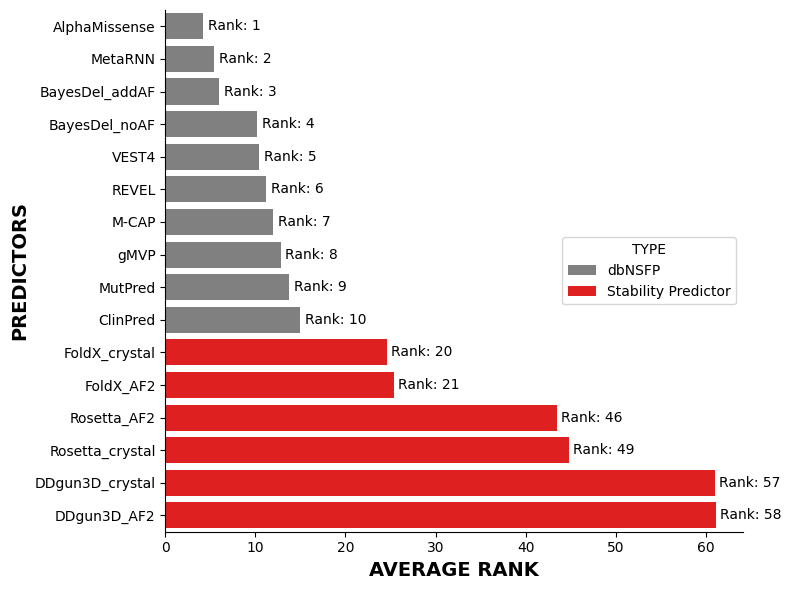

In [192]:
custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red', 'COMB':'yellow'}
plt.figure(figsize=(8, 6))

result_missense_filter_df['name'] = result_missense_filter_df['name'].str.strip()
result_missense_filter_df['name_lower'] = result_missense_filter_df['name'].str.lower()
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=result_missense_filter_df, x='average_rank', y='name', ci=None, hue='TYPE',
                 dodge=False, palette=custom_palette)
for p in ax.patches:
    y_value = p.get_y() + p.get_height() / 2
    name = result_missense_filter_df.iloc[int(y_value)]['name']
    rank = result_missense_filter_df.loc[result_missense_filter_df['name'] == name,
                                         'Rank'].values

    if len(rank) > 0:
        ax.annotate(f'Rank: {rank[0]}', (p.get_x() + p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
plt.xlabel('AVERAGE RANK', fontsize=14, fontweight='bold')  
plt.ylabel('PREDICTORS', fontsize=14, fontweight='bold') 
sns.despine()
plt.tight_layout()
plt.savefig('insilico_predictor_rank.png', dpi=300)
plt.show()


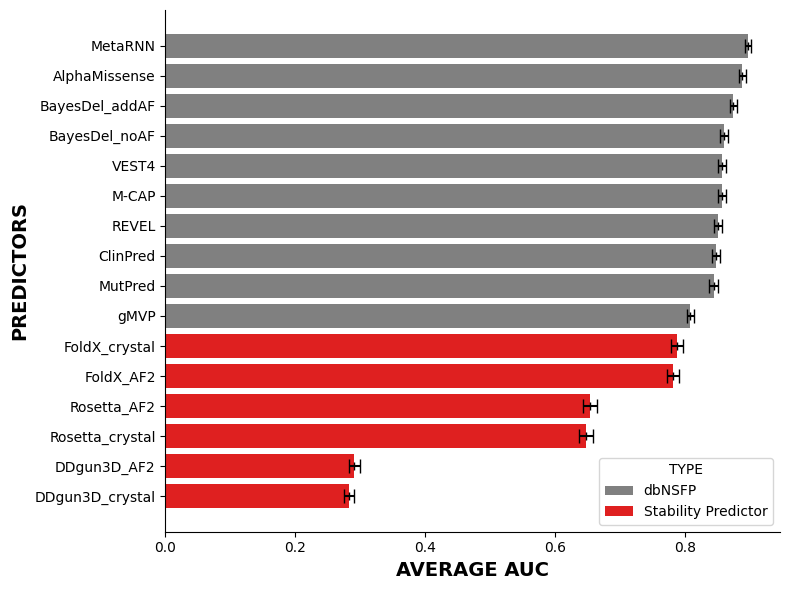

In [194]:
result_missense_filter_auc_df = result_missense_filter_df.sort_values(by="average_AUC", ascending=False)
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=result_missense_filter_auc_df, x='average_AUC', y='name', ci=None, hue='TYPE',
                 dodge=False, palette=custom_palette)
plt.errorbar(x=result_missense_filter_auc_df['average_AUC'], y=range(len(result_missense_filter_auc_df)), 
             xerr=[result_missense_filter_auc_df['average_AUC'] - result_missense_filter_auc_df['average_AUC_CI_low'],
                   result_missense_filter_auc_df['average_AUC_CI_high'] - result_missense_filter_auc_df['average_AUC']], 
             fmt='|', color='black', capsize=5) 

plt.xlabel('AVERAGE AUC', fontsize=14, fontweight='bold')
plt.ylabel('PREDICTORS', fontsize=14, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.savefig('insilico_predictor_AUC.png', dpi=300)
plt.show()

In [195]:
BRCA1_results_filter_df = filter_df_AUC(BRCA1_results_df)
BRCA2_results_filter_df = filter_df_AUC(result_BRCA2_df)
RAD51C_results_filter_df = filter_df_AUC(result_RAD51C_df)
PALB2_results_filter_df = filter_df_AUC(PALB2_result_df)

In [196]:
BRCT_ddg_df = BRCT_df[(BRCT_df['TYPE'] == 'Stability Predictor') & (~BRCT_df['AUC'].isna())]
RING_ddg_df = RING_df[(RING_df['TYPE'] == 'Stability Predictor') & (~RING_df['AUC'].isna())]
BRCA2_results_filter_ddg_df = BRCA2_results_filter_df[BRCA2_results_filter_df['TYPE'] == 'Stability Predictor']
RAD51C_results_filter_ddg_df = RAD51C_results_filter_df[RAD51C_results_filter_df['TYPE']== 'Stability Predictor']
PALB2_results_filter_ddg_df  =PALB2_results_filter_df[PALB2_results_filter_df['TYPE']=='Stability Predictor']

ddg_af2_crystal_df = pd.concat([PALB2_results_filter_ddg_df, RAD51C_results_filter_ddg_df,
                                BRCA2_results_filter_ddg_df, RING_ddg_df, BRCT_ddg_df], axis=0)


ddg_af2_crystal_df[['PREDICTOR', 'MODEL', 'PDB']] = ddg_af2_crystal_df['name'].str.split('_',expand=True)
ddg_af2_crystal_df['PDB_PREDICTOR'] = ddg_af2_crystal_df['PREDICTOR'] +  "_" + ddg_af2_crystal_df['PDB']


ddg_af2_crystal_df['ERROR'] = (ddg_af2_crystal_df['AUC_CI_high'] - ddg_af2_crystal_df['AUC_CI_low']) / 2
ddg_af2_crystal_df[(ddg_af2_crystal_df['GENE'] == 'RAD51C') & 
                   (ddg_af2_crystal_df['MODEL'] == 'AF2') &
                  (ddg_af2_crystal_df['PDB'] == '8FAZ')]


ddg_af2_crystal_df.to_csv("results_AUC_all_results_categorical.csv", index=None)


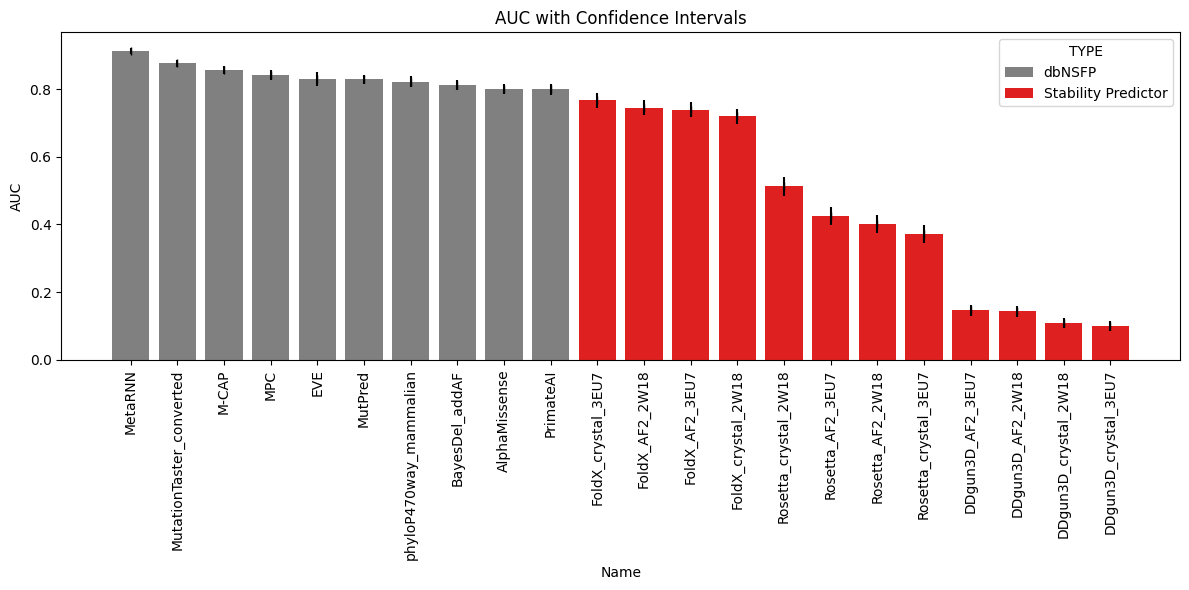

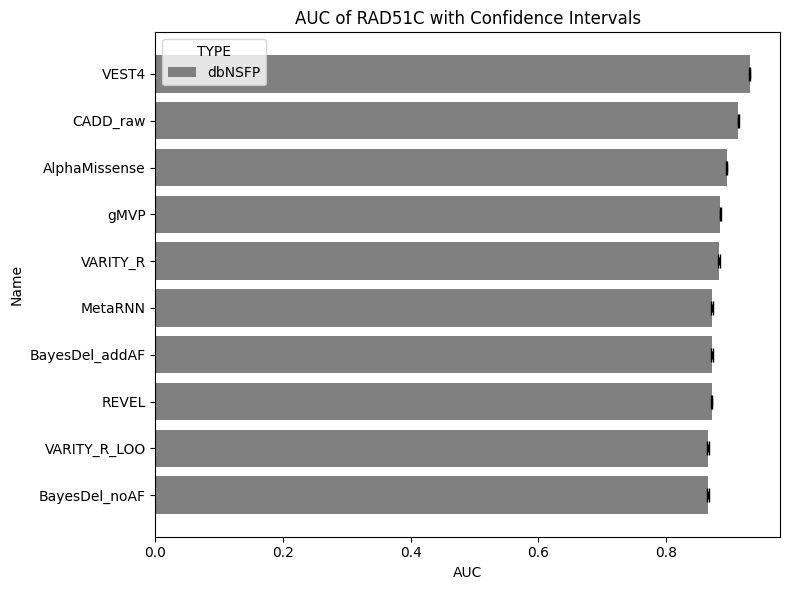

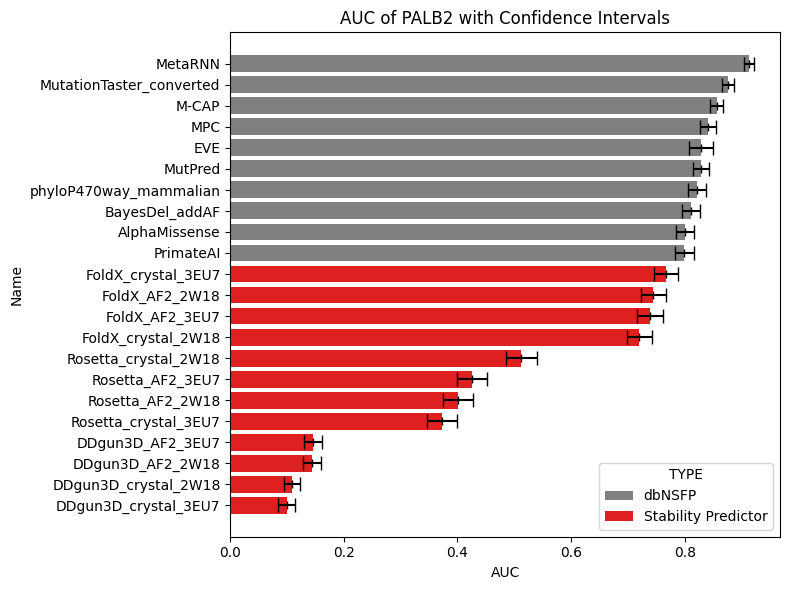

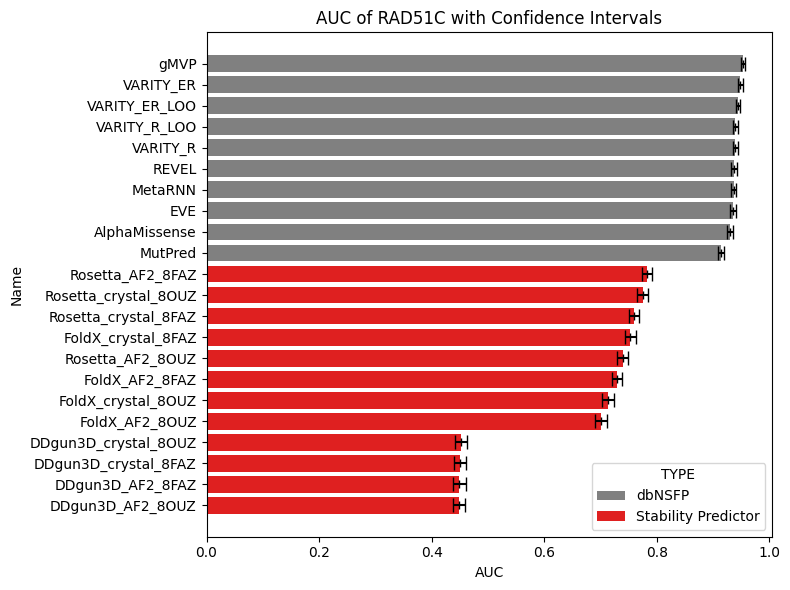

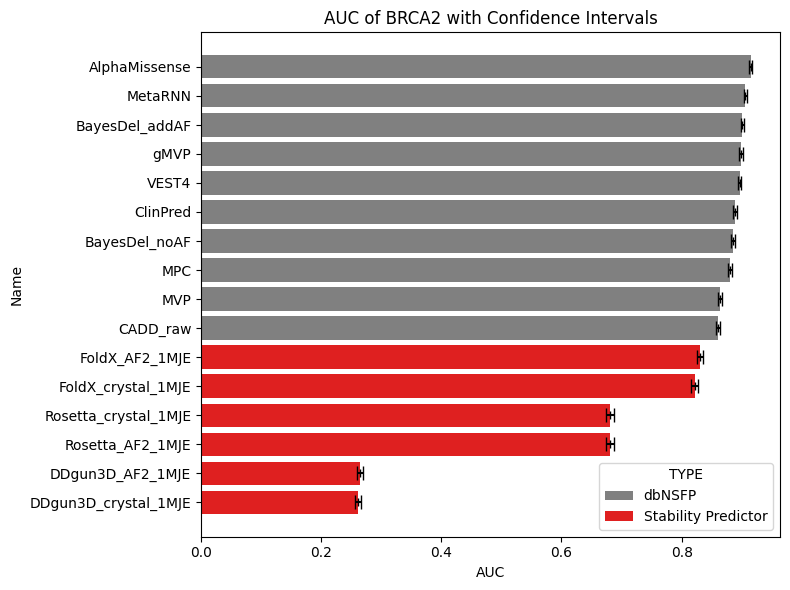

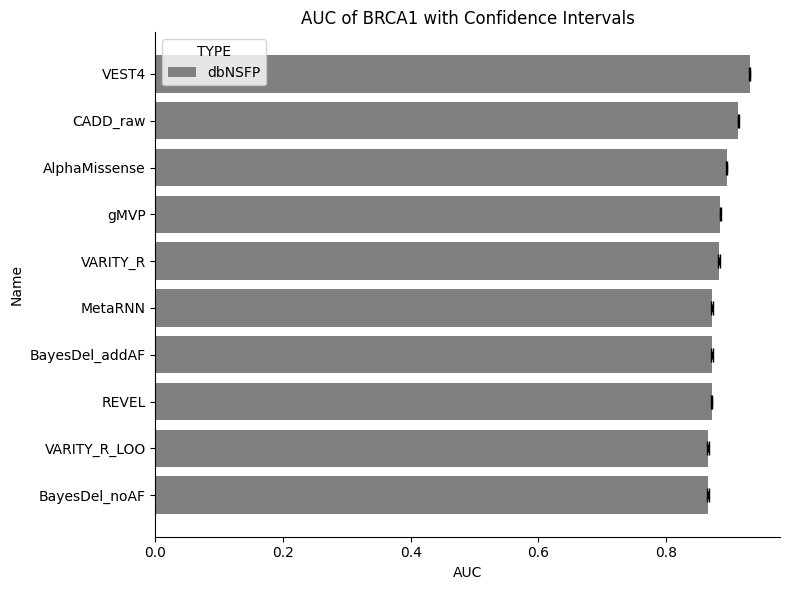

In [197]:
custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(12, 6))
sns.barplot(data=PALB2_results_filter_df, x='name', y='AUC', ci=None,hue='TYPE', dodge=False, palette=custom_palette)  # Plot bars without error bars
plt.errorbar(x=PALB2_results_filter_df.index, y=PALB2_results_filter_df['AUC'], 
             yerr=[PALB2_results_filter_df['AUC'] - PALB2_results_filter_df['AUC_CI_low'],
                   PALB2_results_filter_df['AUC_CI_high'] - PALB2_results_filter_df['AUC']], fmt='|', color='black')  # Add custom error bars
plt.xticks(rotation=90) 
plt.xlabel('Name')
plt.ylabel('AUC')
plt.title('AUC with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=BRCA1_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=BRCA1_results_filter_df['AUC'], y=range(len(BRCA1_results_filter_df)), 
             xerr=[BRCA1_results_filter_df['AUC'] - BRCA1_results_filter_df['AUC_CI_low'],
                   BRCA1_results_filter_df['AUC_CI_high'] - BRCA1_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  
plt.xlabel('AUC') 
plt.ylabel('Name')  
plt.title('AUC of RAD51C with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=PALB2_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=PALB2_results_filter_df['AUC'], y=range(len(PALB2_results_filter_df)), 
             xerr=[PALB2_results_filter_df['AUC'] - PALB2_results_filter_df['AUC_CI_low'],
                   PALB2_results_filter_df['AUC_CI_high'] - PALB2_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  
plt.xlabel('AUC')  
plt.ylabel('Name')  
plt.title('AUC of PALB2 with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=RAD51C_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=RAD51C_results_filter_df['AUC'], y=range(len(RAD51C_results_filter_df)), 
             xerr=[RAD51C_results_filter_df['AUC'] - RAD51C_results_filter_df['AUC_CI_low'],
                   RAD51C_results_filter_df['AUC_CI_high'] - RAD51C_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  
plt.xlabel('AUC')  
plt.ylabel('Name')  
plt.title('AUC of RAD51C with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=BRCA2_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', 
            dodge=False, palette=custom_palette)  
plt.errorbar(x=BRCA2_results_filter_df['AUC'], y=range(len(BRCA2_results_filter_df)), 
             xerr=[BRCA2_results_filter_df['AUC'] - BRCA2_results_filter_df['AUC_CI_low'],
                   BRCA2_results_filter_df['AUC_CI_high'] - BRCA2_results_filter_df['AUC']],
             fmt='|', color='black', capsize=5)  
plt.xlabel('AUC')  
plt.ylabel('Name')  
plt.title('AUC of BRCA2 with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=BRCA1_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', 
            dodge=False, palette=custom_palette)  
plt.errorbar(x=BRCA1_results_filter_df['AUC'], y=range(len(BRCA1_results_filter_df)), 
             xerr=[BRCA1_results_filter_df['AUC'] - BRCA1_results_filter_df['AUC_CI_low'],
                   BRCA1_results_filter_df['AUC_CI_high'] - BRCA1_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  
plt.xlabel('AUC')  
plt.ylabel('Name')  
plt.title('AUC of BRCA1 with Confidence Intervals')
sns.despine()
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

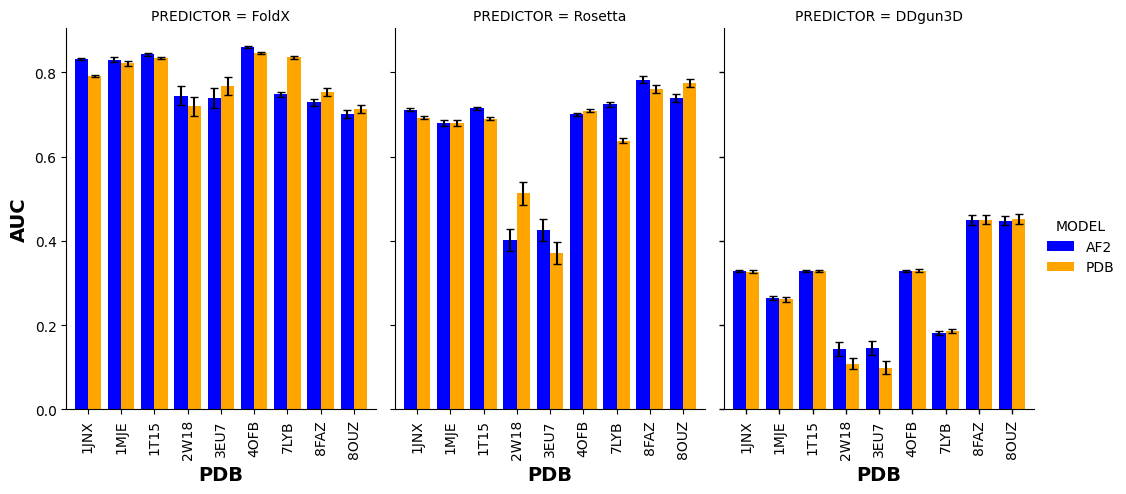

In [198]:
def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    err = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')

    ax = plt.gca()

    p.plot(kind='bar', yerr=err, ax=ax, capsize=3, color=kwargs.get('color', ['blue', 'orange']), width=kwargs.get('width', 0.8))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center') 

ddg_af2_crystal_df['label'] = ddg_af2_crystal_df['MODEL'].apply(lambda x: "PDB" if x == 'crystal' else x)
plt.figure(figsize=(8, 6))
g = sns.FacetGrid(ddg_af2_crystal_df, col="PREDICTOR", height=5, aspect=.7)
g.map_dataframe(errplot, x="PDB", y="AUC", yerr='ERROR', hue="label", color=['blue', 'orange'], width=0.8)
g.add_legend(title="MODEL")
g.set_ylabels('AUC', fontsize=14, fontweight='bold')
g.set_xlabels('PDB', fontsize=14, fontweight='bold')
plt.tick_params(axis='x', width=1)  
plt.tick_params(axis='y', width=1)

plt.savefig('auc_stability_results.png', dpi=300)
plt.show()

In [199]:
result_missense_fpr_df = result_missense_df.sort_values(['average_FPR'], ascending=True)
result_missense_fpr_df = result_missense_fpr_df[['name', 'TYPE','average_rank','average_FPR', 'average_FPR_CI_low', 
                                                 'average_FPR_CI_high']]
result_missense_fpr_df = result_missense_fpr_df.drop_duplicates()
result_missense_fpr_df = result_missense_fpr_df.reset_index(drop=True)

,name,TYPE,average_rank,average_FPR,average_FPR_CI_low,average_FPR_CI_high
0,AlphaMissense,dbNSFP,4.200000,0.139516,0.130896,0.148137
1,MetaRNN,dbNSFP,5.400000,0.143395,0.134262,0.152529
2,gMVP,dbNSFP,12.800000,0.146704,0.137139,0.156270
3,BayesDel_addAF,dbNSFP,6.000000,0.179646,0.169541,0.189750
4,EVE,dbNSFP,20.600000,0.180416,0.167919,0.192912
5,FoldX_crystal,Stability Predictor,24.555556,0.180822,0.169306,0.192339
6,VEST4,dbNSFP,10.400000,0.181351,0.171430,0.191273
7,MutPred,dbNSFP,13.750000,0.182873,0.170144,0.195603
8,ESM1b,dbNSFP,29.000000,0.183685,0.170445,0.196925
9,M-CAP,dbNSFP,12.000000,0.188612,0.179053,0.198171


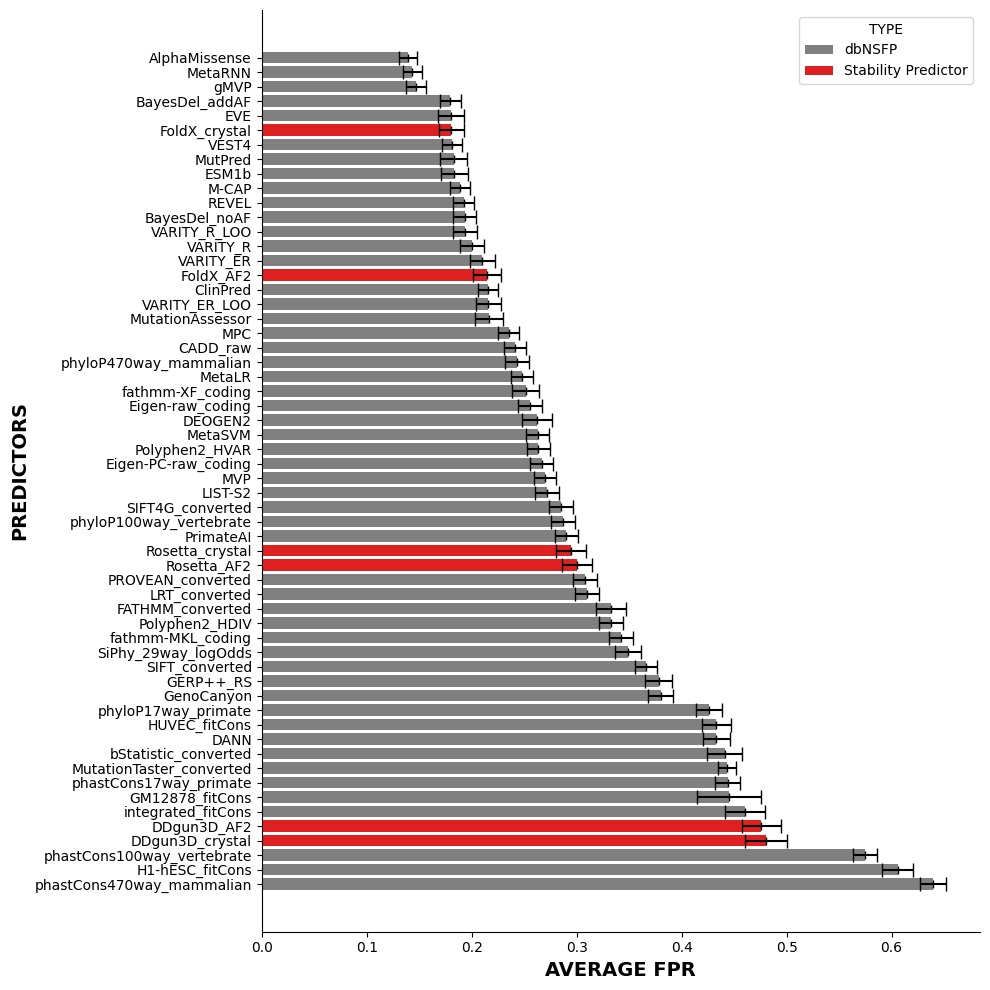

In [200]:
result_missense_df

result_missense_filter_fpr_df = result_missense_fpr_df.sort_values(by="average_FPR", ascending=True)
plt.figure(figsize=(10, 10))
ax = sns.barplot(data=result_missense_filter_fpr_df, x='average_FPR', y='name', ci=None, hue='TYPE',
                 dodge=False, palette=custom_palette)
plt.errorbar(x=result_missense_filter_fpr_df['average_FPR'], y=range(len(result_missense_filter_fpr_df)), 
             xerr=[result_missense_filter_fpr_df['average_FPR'] - result_missense_filter_fpr_df['average_FPR_CI_low'],
                   result_missense_filter_fpr_df['average_FPR_CI_high'] - result_missense_filter_fpr_df['average_FPR']], 
             fmt='|', color='black', capsize=5)  

plt.xlabel('AVERAGE FPR', fontsize=14, fontweight='bold') 
plt.ylabel('PREDICTORS', fontsize=14, fontweight='bold')  
plt.tight_layout()
plt.savefig('insilico_predictor_FPR.png', dpi=300)
plt.show()

In [202]:
result_missense_rank_df = result_missense_df.sort_values(['average_rank'], ascending=True)
result_missense_rank_df = result_missense_rank_df[['name', 'TYPE','average_rank']]
result_missense_rank_df = result_missense_rank_df.drop_duplicates()
result_missense_rank_df = result_missense_rank_df.reset_index(drop=True)
result_missense_rank_df

,name,TYPE,average_rank
0,AlphaMissense,dbNSFP,4.200000
1,MetaRNN,dbNSFP,5.400000
2,BayesDel_addAF,dbNSFP,6.000000
3,BayesDel_noAF,dbNSFP,10.200000
4,VEST4,dbNSFP,10.400000
5,REVEL,dbNSFP,11.200000
6,M-CAP,dbNSFP,12.000000
7,gMVP,dbNSFP,12.800000
8,MutPred,dbNSFP,13.750000
9,ClinPred,dbNSFP,15.000000
